#Major Project
Deep Learning for Automated Detection of Lung Cancer types in Tissue Samples

#Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import warnings
warnings.filterwarnings('ignore')

#Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Unzipping folder

In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/lung_disease/archive_1.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


#Classes

In [4]:
path = '/content/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

#Printing Images

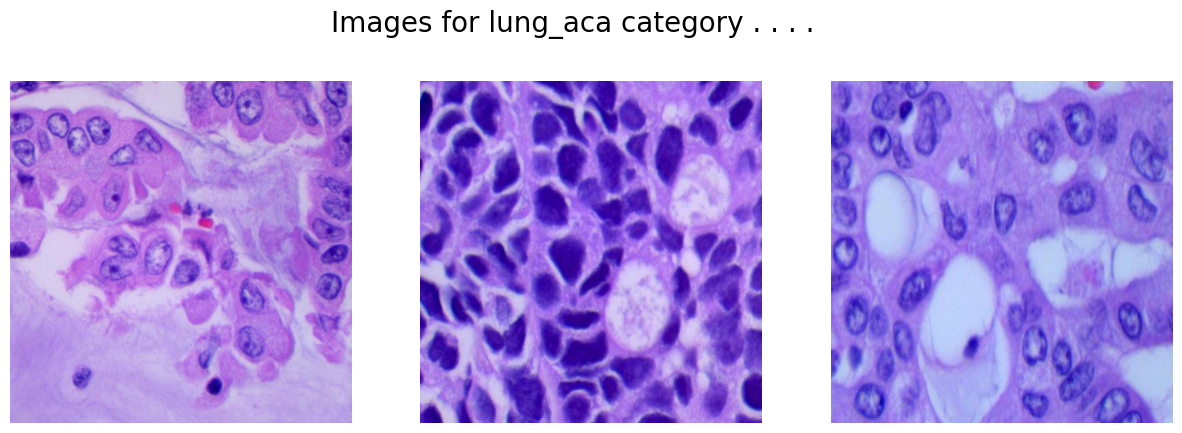

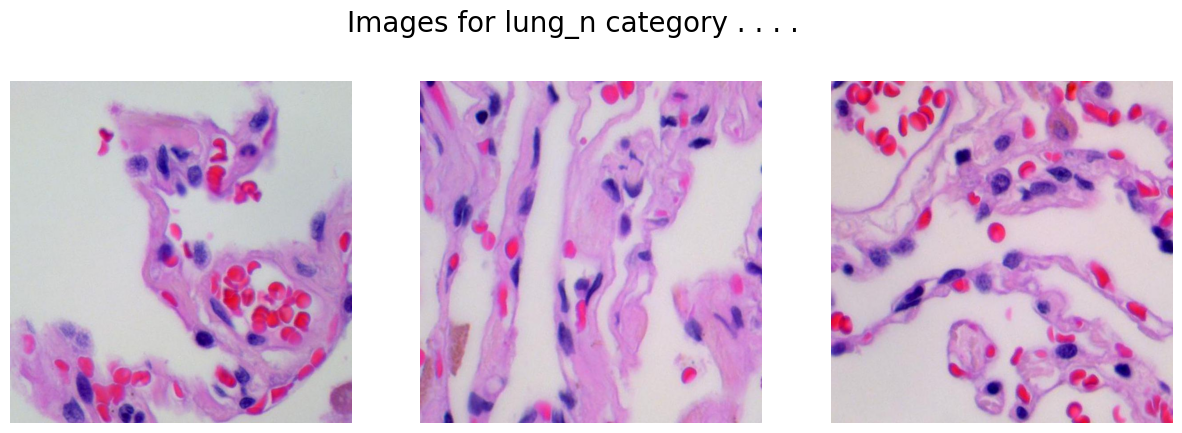

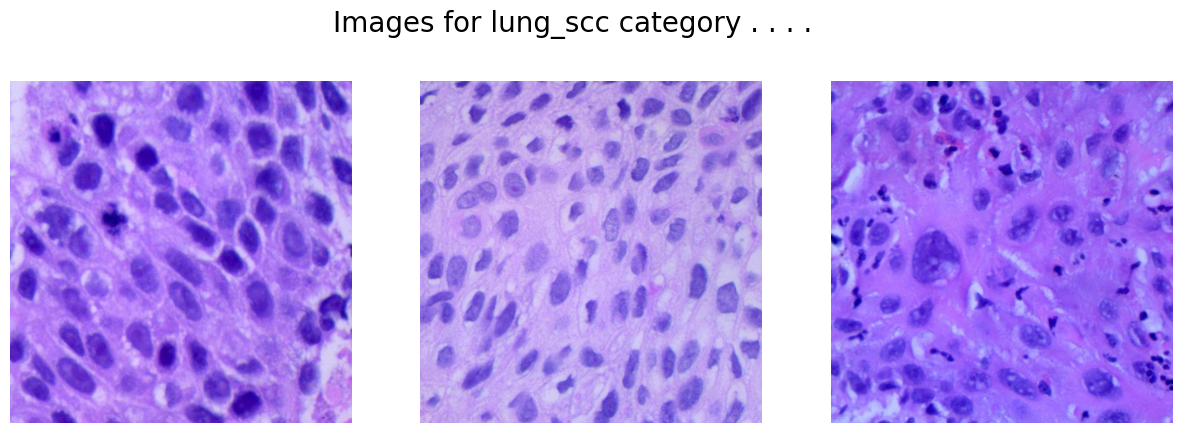

In [5]:
path = '/content/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .',
                 fontsize = 20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

#Hyperparameter Tuning

In [6]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 20
BATCH_SIZE = 16

In [7]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


#Model Training

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
	input_shape = (IMG_SIZE, IMG_SIZE, 3),
	weights = 'imagenet',
	include_top = False
)
# Fine-tuning: Unfreeze top layers
for layer in pre_trained_model.layers[:-50]:
    layer.trainable = False  # Freeze bottom layers
for layer in pre_trained_model.layers[-50:]:
    layer.trainable = True   # Unfreeze top layers

# Build the full model
model = keras.Sequential([
    pre_trained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

# Compile with a low learning rate
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Then train your model as usual
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                    epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 78ms/step - accuracy: 0.6886 - loss: 0.7008 - val_accuracy: 0.8690 - val_loss: 0.3160
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.8632 - loss: 0.3495 - val_accuracy: 0.9017 - val_loss: 0.2510
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.8906 - loss: 0.2805 - val_accuracy: 0.9247 - val_loss: 0.2044
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.9048 - loss: 0.2411 - val_accuracy: 0.9343 - val_loss: 0.1819
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9180 - loss: 0.2036 - val_accuracy: 0.9267 - val_loss: 0.1834
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9329 - loss: 0.1781 - val_accuracy: 0.9447 - val_loss: 0.1449
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9465 - loss: 0.1457 - val_accuracy: 0.9433 - val_loss: 0.1496
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - accuracy: 0.9556 - loss: 0.1231 - 

#Accuracy and Loss

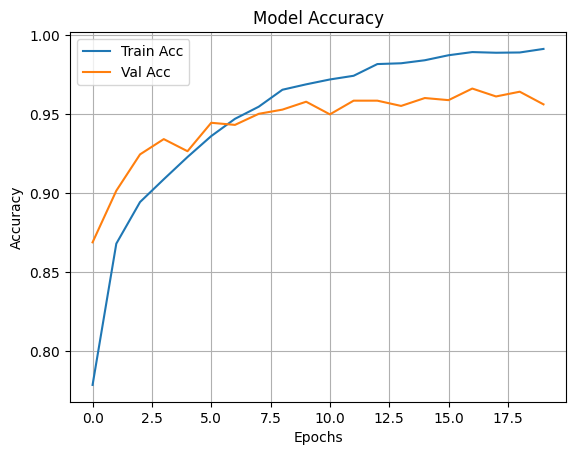

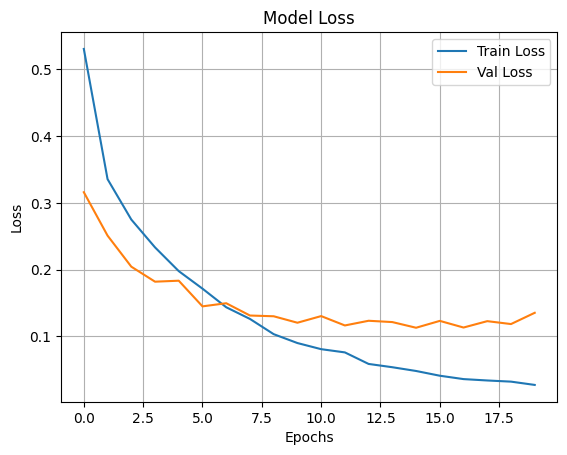

In [22]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#Model Evaluation

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step


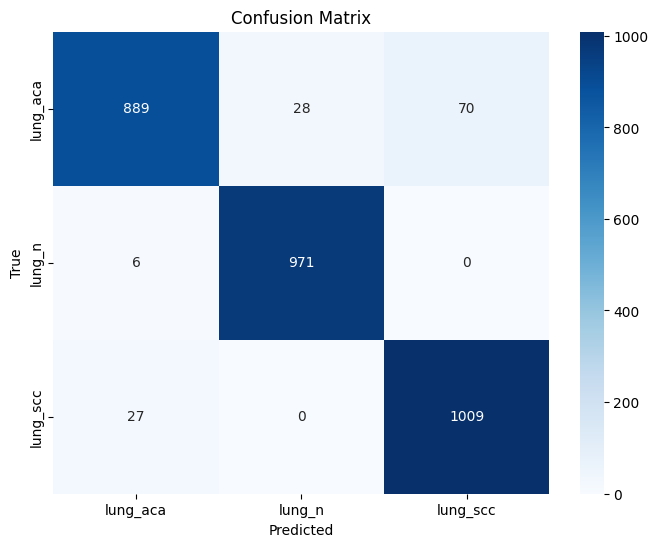

Classification Report:
              precision    recall  f1-score   support

    lung_aca       0.96      0.90      0.93       987
      lung_n       0.97      0.99      0.98       977
    lung_scc       0.94      0.97      0.95      1036

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [24]:
# Predict probabilities
y_pred = model.predict(X_val)

# Convert to predicted and true class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = Y_val  # <--- already class labels, no need for argmax

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))
